In [8]:
using Plots
using Random
rng = MersenneTwister(1234);

# Numerical methods for Itô SDEs

Let's look at the order of convergence of the three schemes discussed in the lectures (Euler-Maruyama, Milstein and Runge-Kutta) using the following linear SDE as a test:
$$
dX_t = \mu X_t dt + \sigma X_t dW_t, \qquad X_0 = x_0
$$

Note the non-constant coefficient in front of $dW_t$ so that we can see differences between the three schemes. 

This is a Geometric Brownian motion (GBM), which arises in financial mathematics (the probability density of this SDE satisfies the Black-Scholes PDE). Its exact solution is
$$
X_t = x_0 \exp\left[(\mu - \sigma^2/2)t + \sigma W_t \right].
$$

Let's write functions to integrate this SDE using Euler-Maruyama, Milstein and Runge-Kutta.

(Codes modified from Higham 2001, https://doi.org/10.1137/S0036144500378302)



In [9]:
# integrates GBM with the Euler--Maruyama scheme starting from x0, with timestep Δt
# and Brownian increments ΔW ~ N(0, Δt)
function EM(Δt, ΔW; μ = 2, σ = 1, x0 = 1)
    N = length(ΔW);     # number of steps of the approximation
    X = zeros(N + 1);
    X[1] = x0;          # initial condition
    for i = 1:N
        X[i+1] = X[i] + μ*X[i] * Δt + σ*X[i]*ΔW[i];
    end
    return X
end

EM (generic function with 1 method)

In [10]:
# integrates GBM with the Milstein scheme starting from x0, with timestep Δt
# and Brownian increments ΔW ~ N(0, Δt)
function Milstein(Δt, ΔW; μ = 2, σ = 1, x0 = 1)
    N = length(ΔW);     # number of steps of the approximation
    X = zeros(N + 1);
    X[1] = x0;          # initial condition
    for i = 1:N
        X[i+1] = X[i] + μ*X[i] * Δt + σ*X[i]*ΔW[i] + 0.5*σ^2*X[i]*(ΔW[i]^2 - Δt);
    end
    return X
end

Milstein (generic function with 1 method)

In [11]:
# integrates GBM with the 2-step Runge-Kutta scheme starting from x0, with timestep Δt
# and Brownian increments ΔW ~ N(0, Δt)
function RK2(Δt, ΔW; μ = 2, σ = 1, x0 = 1)
    N = length(ΔW);     # number of steps of the approximation
    X = zeros(N + 1);
    X[1] = x0;          # initial condition
    for i = 1:N
        Xtemp = X[i] + σ*X[i]*sqrt(Δt);
        X[i+1] = X[i] + μ*X[i] * Δt + σ*X[i]*ΔW[i] + 0.5*σ/sqrt(Δt)*(Xtemp - X[i])*(ΔW[i]^2 - Δt);
    end
    return X
end

RK2 (generic function with 1 method)

# Strong convergence

We are going to use the final time $T$ to measure the strong error:
$$
e_\text{strong} = \mathbb E |X_T - \widehat X_T |,
$$
where $X_T$ is the exact value and $\widehat X_T$ is the approximation. 

Recall that we need to compare pathwise. 

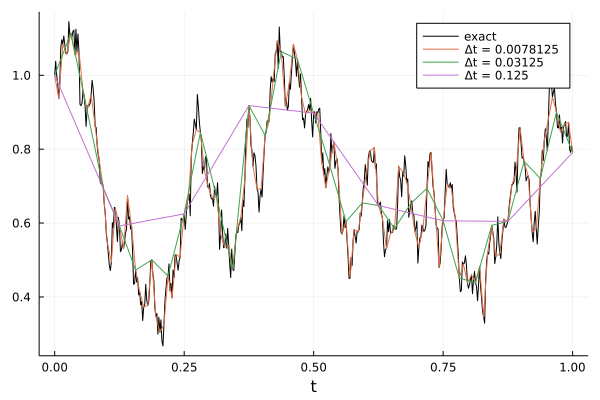

In [12]:
# Consider the Brownian increments
T = 1; N = 2^9; Δt = T/N; 
ΔW = sqrt(Δt)*randn(rng, N);
W = cumsum([1; ΔW]); 
plt = plot(0:Δt:T,W,
    xlabel = "t",
    label = "exact",
    linecolor=:black
)

for p = 3:2:7
    R = 2^(p-1); Dt = R*Δt;
    Wp = W[1:R:end]; 
    plot!(plt, 0:Dt:T, Wp,
        label = "Δt = $Dt"
    )
end
display(plt)


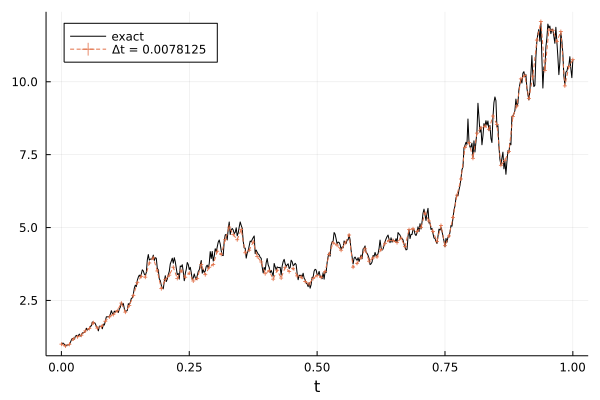

In [13]:
# Solve GBM using EM and compare with exact solution

μ = 2; σ = 1; x0 = 1;           # problem parameters
T = 1; N = 2^9; Δt = T/N; 
ΔW = sqrt(Δt)*randn(rng, N);    # Brownian increments
W = cumsum(ΔW);                 # discretised Brownian path
t = 0:Δt:T;                    # time vector

# exact solution
Xtrue = [x0; x0*exp.((μ - σ^2/2)*t[2:end] .+ σ*W)];
plot(t, Xtrue, 
    xlabel = "t",
    label = "exact",
    linecolor=:black,
    legend = :topleft
)

# approximate solution
R = 4; Dt = R*Δt; L = Int(N/R); 
DW = [sum(ΔW[R*(i-1)+1:R*i]) for i = 1:L]
Xem = EM(Dt, DW; μ = μ, σ = σ, x0 = x0);
plot!(0:Dt:T, Xem, 
    label = "Δt = $Dt",
    markershape = :+,
    markersize = 2,
    linestyle = :dash
)


In [14]:
# Now test the strong order of convergence of the three methods

μ = 2; σ = 1; x0 = 1;           # problem parameters
T = 1; N = 2^9; Δt = T/N; 
M = 1000;                       # number of trajectories used to compute the average
Eem = zeros(5); Emil = zeros(5); Erk = zeros(5);    # preallocate arrays for errors

for s = 1:M
    ΔW = sqrt(Δt)*randn(rng, N);    # Brownian increments
    W = cumsum(ΔW);                 # discretised Brownian path

    Xtrue = x0*exp((μ - σ^2/2)*T + σ*W[end]); # exact solution at T
    for p = 1:5
        R = 2^(p-1); Dt = R*Δt; L = Int(N/R);        # approximate scheme with stepsize Dt
        DW = [sum(ΔW[R*(i-1)+1:R*i]) for i = 1:L];    # coarser Brownian increments
        
        Xem = EM(Dt, DW; μ = μ, σ = σ, x0 = x0);
        Eem[p] += abs(Xem[end] - Xtrue);

        Xmil = Milstein(Dt, DW; μ = μ, σ = σ, x0 = x0);
        Emil[p] += abs(Xmil[end] - Xtrue);

        Xrk = RK2(Dt, DW; μ = μ, σ = σ, x0 = x0);
        Erk[p] += abs(Xrk[end] - Xtrue);
    end
end
# compute the means
Eem = Eem./M; Emil = Emil./M; Erk = Erk./M;

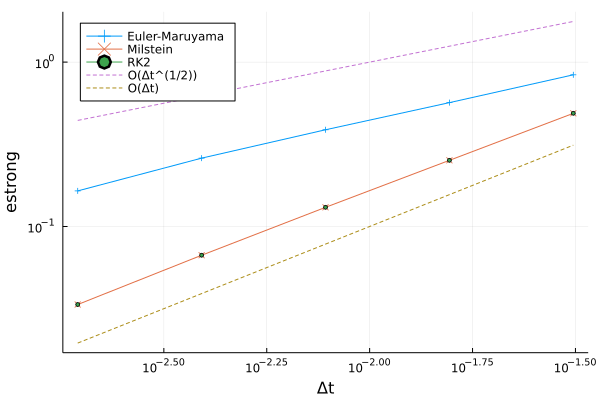

In [15]:
Dts = Δt .* (2 .^ (0:4)); # values of Dt used for the approximations
plot(Dts, Eem, xaxis=:log, yaxis=:log, 
    xlabel = "Δt",
    ylabel = "estrong",
    label = "Euler-Maruyama",
    legend = :topleft,
    markershape = :+,
    markersize = 3
    )

plot!(Dts, Emil, xaxis=:log, yaxis=:log, 
    label = "Milstein",
    markershape = :x,
    markersize = 3
    )

plot!(Dts, Erk, xaxis=:log, yaxis=:log, 
    label = "RK2",
    linewidth = 0,
    markershape = :o,
    markersize = 2
    )

# reference slopes
plot!(Dts, 10*sqrt.(Dts),
    linestyle = :dash,
    label = "O(Δt^(1/2))"
)

plot!(Dts, 10*Dts,
    linestyle = :dash,
    label = "O(Δt)"
)

### Alternative without using the exact solution

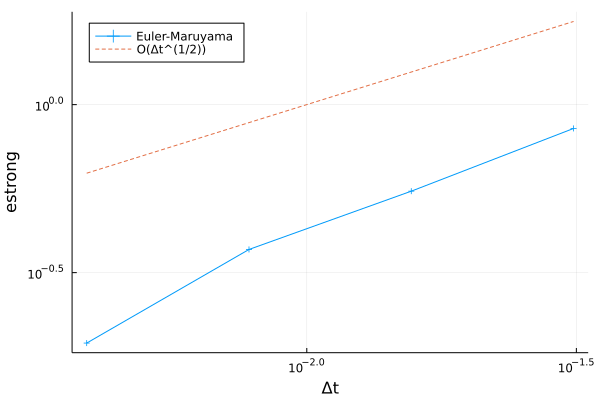

In [16]:
# Now test the strong order of convergence of the three method

μ = 2; σ = 1; x0 = 1;           # problem parameters
T = 1; N = 2^9; Δt = T/N; 
M = 1000;                       # number of trajectories used to compute the average
Eem = zeros(4); 

for s = 1:M
    ΔW = sqrt(Δt)*randn(rng, N);    # Brownian increments
    W = cumsum(ΔW);                 # discretised Brownian path

    X = EM(Δt, ΔW; μ = μ, σ = σ, x0 = x0);          # approximation using finest grid
    Xfine = X[end]; 
    for p = 1:4
        R = 2^p; Dt = R*Δt; L = Int(N/R);        # approximate scheme with stepsize Dt
        DW = [sum(ΔW[R*(i-1)+1:R*i]) for i = 1:L];    # coarser Brownian increments
        
        Xem = EM(Dt, DW; μ = μ, σ = σ, x0 = x0);
        Eem[p] += abs(Xem[end] - Xfine);
    end
end
# compute the mean
Eem = Eem./M;

Dts = Δt .* (2 .^ (1:4)); # values of Dt used for the approximations
plot(Dts, Eem, xaxis=:log, yaxis=:log, 
    xlabel = "Δt",
    ylabel = "estrong",
    label = "Euler-Maruyama",
    legend = :topleft,
    markershape = :+,
    markersize = 3
    )

# reference slope
plot!(Dts, 10*sqrt.(Dts),
    linestyle = :dash,
    label = "O(Δt^(1/2))"
)

# Weak convergence

We use the final time $T$ and $f(x) = x$ to measure the weak error:
$$
e_\text{weak} = |\mathbb E X_T  - \mathbb E \widehat X_T |,
$$
where $X_T$ is the exact value and $\widehat X_T$ is the approximation. 

We will use
$$
\mathbb E X_T = e^{\mu T}.
$$

In [25]:
# Now test the weak order of convergence of the three methods

μ = 2; σ = 1; x0 = 1;           # problem parameters
T = 1;
M = 10^3;                       # number of trajectories used to compute the average (increase to reduce sampling error)
pin = (1:5);
Xem = zeros(length(pin)); Xmil = zeros(length(pin)); # preallocate arrays for errors

Xtrue = exp(μ*T); # expected value of the true solution

for p ∈ pin
    Dt = 2.0^(p-10); L = Int(T/Dt);      # approximate scheme with stepsize Dt
    DW = sqrt(Dt)*randn(rng,L,M);        # Brownian increments

    for j = 1:M
        X = EM(Dt, DW[:,j]; μ = μ, σ = σ, x0 = x0);
        Xem[p] += X[end];

        X = Milstein(Dt, DW[:,j]; μ = μ, σ = σ, x0 = x0);
        Xmil[p] += X[end];
    end
end
# compute the means
Xem = Xem./M; Xmil = Xmil./M; 
Eem  = abs.(Xem .- Xtrue); 
Emil = abs.(Xmil .- Xtrue);


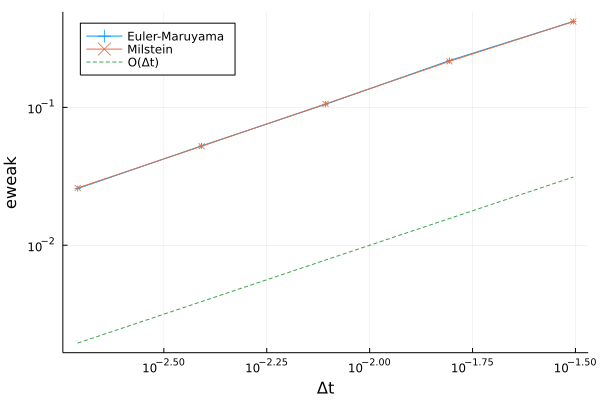

In [26]:
# plot weak convergence results

Dts = 2.0 .^ (pin .-10); # values of Dt used for the approximations
plot(Dts, Eem, xaxis=:log, yaxis=:log, 
    xlabel = "Δt",
    ylabel = "eweak",
    label = "Euler-Maruyama",
    legend = :topleft,
    markershape = :+,
    markersize = 3,
        )

plot!(Dts, Emil, xaxis=:log, yaxis=:log, 
    label = "Milstein",
    markershape = :x,
    markersize = 3
    )

# reference slopes
plot!(Dts, Dts,
    linestyle = :dash,
    label = "O(Δt)"
)